## Import Library

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm

## Konfigurasi dan Hyperparameter

In [2]:
BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_EPOCHS = 15
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Menggunakan device: {DEVICE}")

MEAN = 0.1307
STD = 0.3081

Menggunakan device: cuda


## Preprocessing Data

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((MEAN,), (STD,))
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"Jumlah sampel pelatihan: {len(train_dataset)}")
print(f"Jumlah sampel pengujian: {len(test_dataset)}")
print(f"Jumlah batch pelatihan: {len(train_loader)}")
print(f"Jumlah batch pengujian: {len(test_loader)}")

Jumlah sampel pelatihan: 60000
Jumlah sampel pengujian: 10000
Jumlah batch pelatihan: 938
Jumlah batch pengujian: 157


## Arsitektur Model CNN

In [4]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64) # Menormalisasi output dari conv2
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.25)

        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.dropout3 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.dropout1(x)

        # Block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.dropout2(x)

        x = x.view(-1, 64 * 7 * 7)

        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout3(x)

        x = self.fc2(x)
        return x

model = SimpleCNN(num_classes=10).to(DEVICE)
print(model)

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


## Fungsi Training dan Evaluation

In [5]:
def train_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for batch_idx, (data, target) in enumerate(tqdm(train_loader, desc=f"Training")):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * data.size(0)
        _, predicted = torch.max(output.data, 1)
        total_samples += target.size(0)
        correct_predictions += (predicted == target).sum().item()

    epoch_loss = running_loss / total_samples
    epoch_accuracy = correct_predictions / total_samples
    return epoch_loss, epoch_accuracy

def evaluate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target in tqdm(loader, desc=f"Evaluating"):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)

            running_loss += loss.item() * data.size(0)
            _, predicted = torch.max(output.data, 1)
            total_samples += target.size(0)
            correct_predictions += (predicted == target).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    epoch_loss = running_loss / total_samples
    epoch_accuracy = correct_predictions / total_samples
    return epoch_loss, epoch_accuracy, np.array(all_preds), np.array(all_targets)

## Training Loop Utama

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

print("Memulai pelatihan...")
for epoch in range(1, NUM_EPOCHS + 1):
    print(f"\n--- Epoch {epoch}/{NUM_EPOCHS} ---")
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, DEVICE)
    val_loss, val_acc, _, _ = evaluate_epoch(model, test_loader, criterion, DEVICE)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Train Acc = {train_acc:.4f} | "
          f"Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}")

print("\nPelatihan selesai!")

Memulai pelatihan...

--- Epoch 1/15 ---


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.3043, Train Acc = 0.9064 | Val Loss = 0.0571, Val Acc = 0.9830

--- Epoch 2/15 ---


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2: Train Loss = 0.1404, Train Acc = 0.9586 | Val Loss = 0.0489, Val Acc = 0.9854

--- Epoch 3/15 ---


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3: Train Loss = 0.1149, Train Acc = 0.9650 | Val Loss = 0.0367, Val Acc = 0.9877

--- Epoch 4/15 ---


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4: Train Loss = 0.1002, Train Acc = 0.9700 | Val Loss = 0.0298, Val Acc = 0.9899

--- Epoch 5/15 ---


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5: Train Loss = 0.0866, Train Acc = 0.9742 | Val Loss = 0.0291, Val Acc = 0.9906

--- Epoch 6/15 ---


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 6: Train Loss = 0.0805, Train Acc = 0.9759 | Val Loss = 0.0274, Val Acc = 0.9911

--- Epoch 7/15 ---


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 7: Train Loss = 0.0731, Train Acc = 0.9787 | Val Loss = 0.0234, Val Acc = 0.9919

--- Epoch 8/15 ---


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 8: Train Loss = 0.0656, Train Acc = 0.9797 | Val Loss = 0.0297, Val Acc = 0.9907

--- Epoch 9/15 ---


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 9: Train Loss = 0.0619, Train Acc = 0.9816 | Val Loss = 0.0248, Val Acc = 0.9924

--- Epoch 10/15 ---


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 10: Train Loss = 0.0577, Train Acc = 0.9822 | Val Loss = 0.0254, Val Acc = 0.9924

--- Epoch 11/15 ---


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 11: Train Loss = 0.0551, Train Acc = 0.9834 | Val Loss = 0.0221, Val Acc = 0.9935

--- Epoch 12/15 ---


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 12: Train Loss = 0.0539, Train Acc = 0.9834 | Val Loss = 0.0226, Val Acc = 0.9927

--- Epoch 13/15 ---


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 13: Train Loss = 0.0506, Train Acc = 0.9842 | Val Loss = 0.0218, Val Acc = 0.9926

--- Epoch 14/15 ---


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 14: Train Loss = 0.0468, Train Acc = 0.9854 | Val Loss = 0.0215, Val Acc = 0.9937

--- Epoch 15/15 ---


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 15: Train Loss = 0.0465, Train Acc = 0.9853 | Val Loss = 0.0191, Val Acc = 0.9939

Pelatihan selesai!


## Visualisasi dan Analisis Hasil

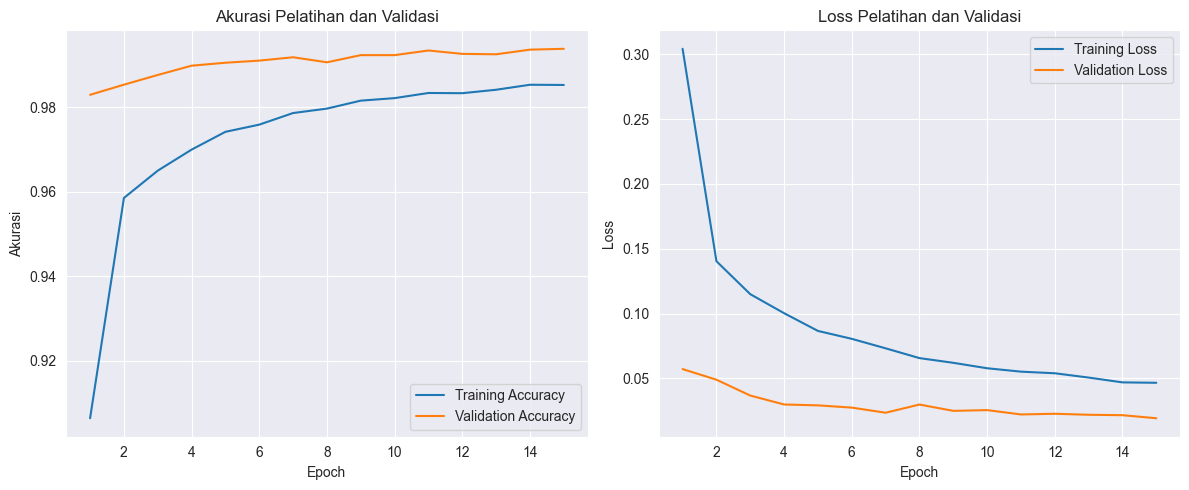


--- Confusion Matrix ---


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

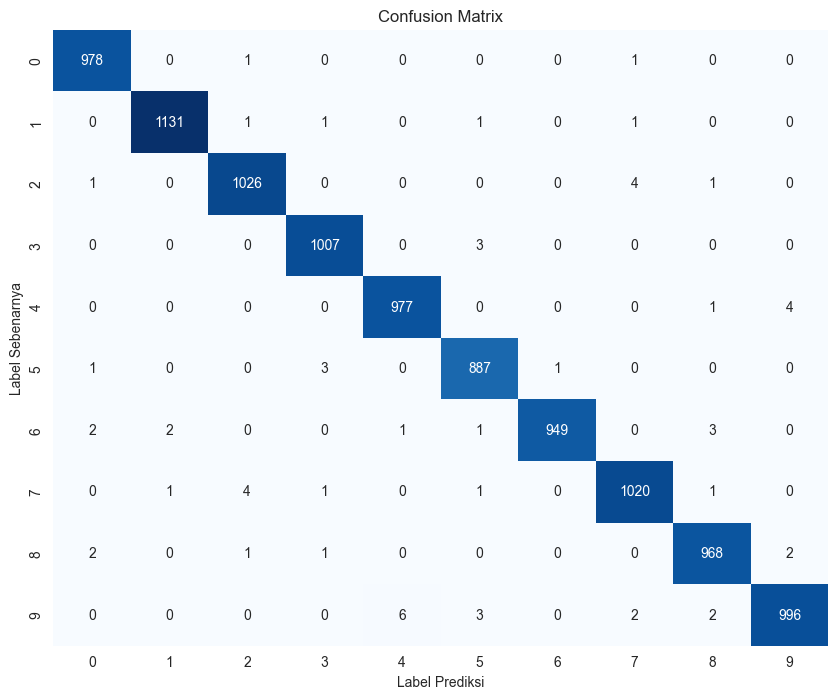


--- Contoh Gambar yang Salah Diklasifikasikan ---


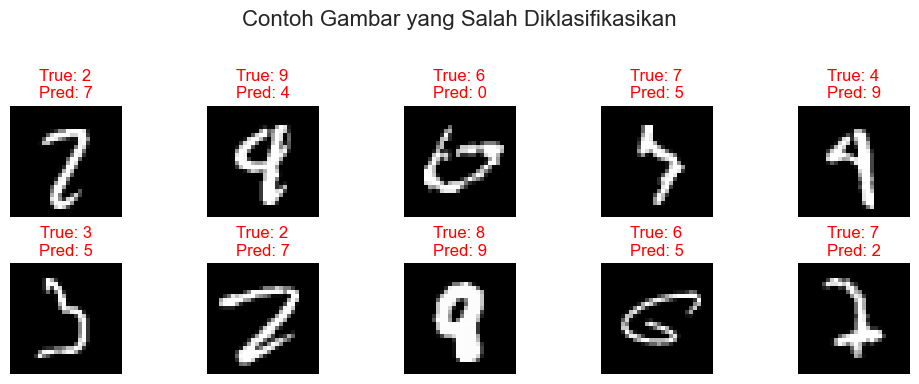

In [7]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, NUM_EPOCHS + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, NUM_EPOCHS + 1), val_accuracies, label='Validation Accuracy')
plt.title('Akurasi Pelatihan dan Validasi')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label='Training Loss')
plt.plot(range(1, NUM_EPOCHS + 1), val_losses, label='Validation Loss')
plt.title('Loss Pelatihan dan Validasi')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("\n--- Confusion Matrix ---")

final_val_loss, final_val_acc, all_preds, all_targets = evaluate_epoch(model, test_loader, criterion, DEVICE)

cm = confusion_matrix(all_targets, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=[str(i) for i in range(10)],
            yticklabels=[str(i) for i in range(10)])
plt.xlabel('Label Prediksi')
plt.ylabel('Label Sebenarnya')
plt.title('Confusion Matrix')
plt.show()

print("\n--- Contoh Gambar yang Salah Diklasifikasikan ---")
model.eval()
misclassified_images = []
misclassified_labels = []
misclassified_preds = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(DEVICE), target.to(DEVICE)
        output = model(data)
        _, predicted = torch.max(output.data, 1)


        incorrect_indices = (predicted != target).nonzero(as_tuple=True)[0]
        for idx in incorrect_indices:
            if len(misclassified_images) < 10:

                misclassified_images.append(data[idx].cpu().squeeze().numpy())
                misclassified_labels.append(target[idx].item())
                misclassified_preds.append(predicted[idx].item())
            else:
                break
        if len(misclassified_images) >= 10:
            break

if misclassified_images:
    plt.figure(figsize=(10, 4))
    for i, (image, true_label, pred_label) in enumerate(zip(misclassified_images, misclassified_labels, misclassified_preds)):
        plt.subplot(2, 5, i + 1)
        plt.imshow(image, cmap='gray')

        plt.title(f'True: {true_label}\nPred: {pred_label}', color='red' if true_label != pred_label else 'black')
        plt.axis('off') # Sembunyikan sumbu
    plt.suptitle('Contoh Gambar yang Salah Diklasifikasikan', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
else:
    print("Tidak ada gambar yang salah diklasifikasikan yang ditemukan (atau model sudah sempurna).")